In [10]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os


(490, 955, 3)


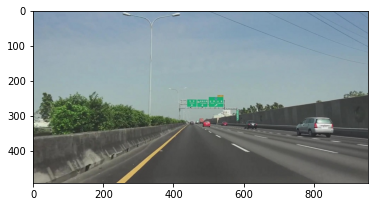

In [11]:
#%% Load pic 
P = './data'
F = 'test02.jpg'
img = cv2.imread(os.path.join(P, F))
img = img[:,:,[2,1,0]]

#====================
plt.imshow(img)
print(img.shape)

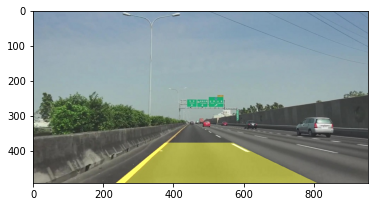

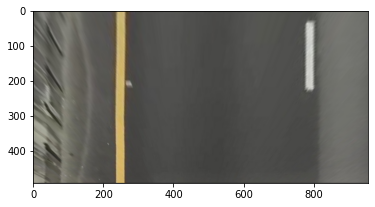

In [12]:
#%% Transform
src = np.float32(
            [[235, 490],  # Bottom left
             [375, 375],  # Top left
             [570, 375],  # Top right
             [810, 490]]) # Bottom right

dst = np.float32(
            [[235, 490],  # Bottom left
             [235, 0],  # Top left
             [810, 0],  # Top right
             [810, 490]]) # Bottom right  

img_size = (img.shape[1], img.shape[0])
M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)
img_warped = cv2.warpPerspective(img, M, img_size) 
 
#====================
region = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)
cv2.fillConvexPoly(region, np.int_([src]), (100, 100, 0))
region_mask = cv2.addWeighted(img, 1, region, 1, 0)

fig_0 = plt.figure(0)
plt.imshow(region_mask)
fig_1 = plt.figure(1)
plt.imshow(img_warped)


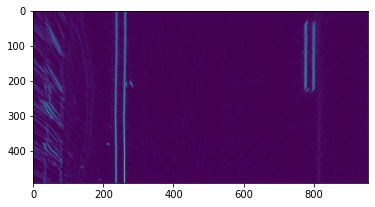

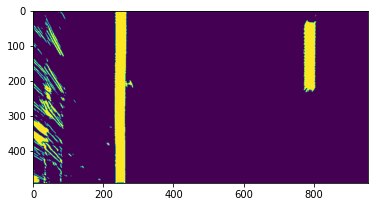

In [13]:
#%% Binary
gray_img =cv2.cvtColor(img_warped, cv2.COLOR_BGR2GRAY)
sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
abs_sobelx = np.absolute(sobelx)
# Scale result to 0-255
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

fig_0 = plt.figure(0)
plt.imshow(scaled_sobel)

sx_binary = np.zeros_like(scaled_sobel)
# Keep only derivative values that are in the margin of interest
sx_binary[(scaled_sobel >= 30) & (scaled_sobel <= 255)] = 1
# Detect pixels that are white in the grayscale image
white_binary = np.zeros_like(gray_img)
white_binary[(gray_img > 150) & (gray_img <= 255)] = 1
# Combine all pixels detected above
binary_warped = cv2.bitwise_or(sx_binary, white_binary)

#====================
fig_1 = plt.figure(1)
plt.imshow(binary_warped)

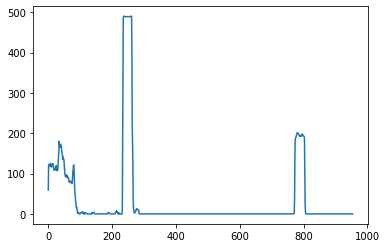

In [14]:
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped, axis=0)

#====================
plt.plot(np.arange(binary_warped.shape[1]), histogram)

In [15]:
midpoint = int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
laneBase = [leftx_base, rightx_base]

#====================
print(leftx_base)
print(rightx_base)

236
780


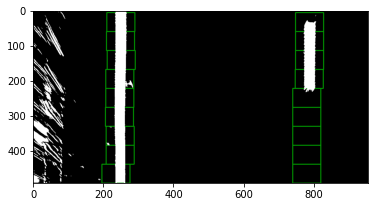

In [16]:
nwindows = 9
margin = 40
minpixel = 50

out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
line_img = np.zeros_like(out_img)
laneLine_y = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
laneLine_x = np.zeros([2, binary_warped.shape[0]])
for n_lane in range(len(laneBase)): 
    window_height = int(binary_warped.shape[0]//nwindows)
    x_point = []
    y_point = []
    laneCurrent = laneBase[n_lane]
    for n_window in range(nwindows):
        x_range_L = laneCurrent - margin
        x_range_R = laneCurrent + margin
        if x_range_L < 0:
            x_range_L = 0
        if x_range_R >= binary_warped.shape[1]:
            x_range_R = binary_warped.shape[1] - 1

        y_range_B = binary_warped.shape[0] - (n_window+1)*window_height
        y_range_T = binary_warped.shape[0] - n_window*window_height

        window = binary_warped[y_range_B:y_range_T, x_range_L:x_range_R]

        y_Nz, x_Nz = np.nonzero(window)
        x_Nz = x_Nz + x_range_L
        y_Nz = y_Nz + y_range_B

        if np.count_nonzero(window) > minpixel:
            x_point.extend(x_Nz)
            y_point.extend(y_Nz)
            laneCurrent = int(np.mean(x_Nz, axis=0))
            
        # 擬合二次曲線
        if len(y_point) > 0:     
            fit = np.polyfit(y_point, x_point, 2)
            # 轉換為點
            laneLine_x[n_lane, :] = fit[0] * laneLine_y**2 + fit[1] * laneLine_y + fit[2]

#====================
        cv2.rectangle(window_img, (x_range_L, y_range_B), (x_range_R, y_range_T), (0,255,0), 2)
img_add = cv2.addWeighted(window_img, 0.6, out_img, 1, 0)
plt.imshow(img_add)

In [17]:
width = 7
threshold = 60
for line_x in laneLine_x:
    if np.abs(line_x[-1]-line_x[0]) > threshold:
        continue
    if np.abs(line_x[-1] - line_x[len(line_x)//2]) > threshold:
        continue
    if np.abs(line_x[0] - line_x[len(line_x)//2]) > threshold:
        continue

    # 線段左邊界
    lineWindow1 = np.expand_dims(np.vstack([line_x - width, laneLine_y]).T, axis=0)
    # 線段右邊界
    lineWindow2 = np.expand_dims(np.flipud(np.vstack([line_x + width, laneLine_y]).T), axis=0)
    linePts = np.hstack((lineWindow1, lineWindow2))

    # 使用 openCV 填上曲線間區域
    cv2.fillPoly(line_img, np.int32([linePts]), (0, 0, 255))

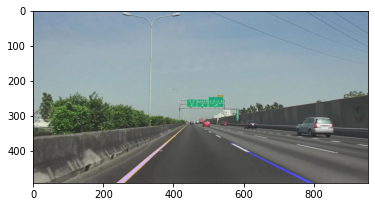

In [18]:
weight = cv2.warpPerspective(line_img, M_inv, (img.shape[1], img.shape[0]))
result = cv2.addWeighted(img, 1, weight, 1, 0)

#====================
plt.imshow(result)